In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
#different
interval = 500
num_inserts = 2
offset = 20000
valid_size = 200
valid_text = text[offset:offset+valid_size]
position = offset+valid_size
inserts_counter = 0
train_text = u''
while (position < len(text)) and inserts_counter < num_inserts:
    train_text += valid_text
    train_text += text[position:position+interval]
    position += interval
    inserts_counter += 1
train_text += text[position:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99360200 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana
200 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [5]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [6]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'ture in Mut', u'e and patho', u'xander Grah', u'life==\nFrom', u'd Roman rem', u'] hero, son', u'       <use', u'   Aspen/Bo', u'<id>2266</i', u'[[2001]])\n*', u'ndi]] until', u't it is eas', u'caceae and ', u's]] boron c', u"Mormon'' is", u'ld War I]],', u'or league a', u'surrounded ', u'66 batman m', u'ong (Banda ', u'd for time ', u'a]]&quot;. ', u'onditions a', u'to such exc', u'esidue at t', u'opir/facts.', u'haracter re', u'   (10, 0, ', u'ubmed&amp;p', u'SI]] standa', u'tential con', u'ce quotient', u' its indepe', u'(d. [[1987]', u'l productio', u' similarly ', u'the [[Rig V', u'gers like [', u' and use co', u"les ==\n'''N", u'tanley Kubr', u'if Johansen', u'It is publi', u'ms Act 1927', u'ra|associat', u'=280 Linux4', u'f name=&quo', u'economics]]', u'tle]]s), of', u' started th', u'ource on al', u'ds the gove', u'f [[black]]', u'otations ==', u']] called [', u' Moray]] on', u'Malaya. UMN', u'ary peers, ', u'ry also con', u'dening furt', u'itution it ', u'[[Indiana U', u'NT

In [7]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class delay_deterministic(MODEL):
    
    def analize(self, compressed_inp):
        memory_concat = list(self.Sample_Memory[0])
        memory_concat.append(compressed_inp)
        for num_layer in range(1, self._memory_layers):
            memory_concat.extend(self.Sample_Memory[num_layer])
        X = tf.concat(1, memory_concat)
        for Analisys_Matrix, Analisys_Bias in zip(self.Analisys_Matrices, self.Analisys_Biases):
            X = tf.nn.relu(tf.nn.xw_plus_b(X, Analisys_Matrix, Analisys_Bias))
        return X 
    
    def update_below_including_layer(self, compressed_inp, layer_num):
        assign_list = list()
        not_changed_layers = [i for i in range(layer_num+1, self._memory_layers)]
        not_changed_layers.sort(reverse=True)
        for lay_num in not_changed_layers:
            assign_list.extend(self.Sample_Memory[lay_num])
        
        if layer_num > 0:
            layers_in_cycle = [i for i in range(1, layer_num+1)]
            layers_in_cycle.sort(reverse=True)
            for lay_num in layers_in_cycle:
                for block_num in range(self._memory_lengths[lay_num]-1):
                    with tf.control_dependencies(assign_list):
                        assign_list.append(tf.assign(self.Sample_Memory[lay_num][block_num], self.Sample_Memory[lay_num][block_num+1]))
                lower_layer_summary = tf.concat(1, self.Sample_Memory[lay_num-1])
                new_block = tf.tanh(tf.nn.xw_plus_b(lower_layer_summary,
                                                    self.Compress_Matrices[lay_num],
                                                    self.Compress_Biases[lay_num]))
                with tf.control_dependencies(assign_list):
                    assign_list.append(tf.assign(self.Sample_Memory[lay_num][self._memory_lengths[lay_num]-1], new_block))
        for block_num in range(self._memory_lengths[0]-1):
            with tf.control_dependencies(assign_list):
                assign_list.append(tf.assign(self.Sample_Memory[0][block_num], self.Sample_Memory[0][block_num+1]))
        with tf.control_dependencies(assign_list):
            assign_list.append(tf.assign(self.Sample_Memory[0][self._memory_lengths[0]-1], compressed_inp))
        return assign_list
    
    def update_memory(self, compressed_inp, layer_num):
        if layer_num > 0:
            assign_list = tf.cond(tf.equal(tf.mod(self.counter, tf.constant(self.abs_freqs[layer_num], dtype=tf.int32)),
                                           tf.constant(0, dtype=tf.int32)),
                                  lambda: self.update_below_including_layer(compressed_inp, layer_num),
                                  lambda: self.update_memory(compressed_inp, layer_num-1))  
        else:
            assign_list = self.update_below_including_layer(compressed_inp, 0)
        return assign_list

    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 memory_layers,
                 memory_nodes,
                 memory_lengths,            # list of memory lengths for all memory levels
                 analisys_layers,
                 analisys_nodes,
                 frequency,              # number of times the highest memory layer fully updates during one epoch
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 init_learning_rate=1.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        
        self._num_unrollings = memory_lengths[0]
        for num_layer in range(1, memory_layers):
            self._num_unrollings *= memory_lengths[num_layer]
        self._num_unrollings *= frequency

        self._memory_layers = memory_layers
        self._memory_nodes = memory_nodes
        self._memory_lengths = memory_lengths
        self._analisys_layers = analisys_layers
        self._analisys_nodes = analisys_nodes
        self._frequency = frequency
        self._init_bias = init_bias
        self._threshold = threshold
        self._normal_run_prob = normal_run_prob
        self._swap_prob = swap_prob
        self._support = support
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        
        
        self._mean = mean
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.4
        else:
            self._stddev = stddev

        self._init_learning_rate = init_learning_rate
  
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "memory_layers": 2,
                         "memory_nodes": 3,
                         "memory_lengths": 4,
                         "analisys_layers": 5,
                         "analisys_nodes": 6,
                         "frequency": 7,
                         "half_life": 8,
                         "decay": 9,
                         "num_steps": 10,
                         "averaging_number": 11,
                         "init_mean": 12,
                         "init_stddev": 13,
                         "init_learning_rate": 14,                         
                         "type": 15}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Saved_Memory = list()
                for layer_num in range(self._memory_layers):
                    layer_memory = list()
                    for _ in range(self._memory_lengths[layer_num]):
                        layer_memory.append(tf.Variable(tf.zeros([self._batch_size, self._memory_nodes[layer_num]]),
                                                        trainable=False))
                    self.Saved_Memory.append(layer_memory)
                self.Compress_Matrices = list()
                self.Compress_Biases = list()
                self.Compress_Matrices.append(
                    tf.Variable(tf.truncated_normal([self._vocabulary_size, self._memory_nodes[0]], mean=self._mean, stddev =self._stddev / self._vocabulary_size**0.5),
                                trainable=True)
                                        )
    
                self.Compress_Biases.append(
                    tf.Variable(tf.zeros([self._memory_nodes[0]]),
                                trainable=True)
                                       )
                for layer_num in range(1, self._memory_layers):
                    self.Compress_Matrices.append(
                        tf.Variable(tf.truncated_normal([self._memory_lengths[layer_num-1]*self._memory_nodes[layer_num-1],
                                                         self._memory_nodes[layer_num]],
                                                        mean=self._mean,
                                                        stddev = self._stddev / (self._memory_lengths[layer_num-1]*self._memory_nodes[layer_num-1])**0.5),
                                    trainable=True)
                                                 )
                    self.Compress_Biases.append(
                        tf.Variable(tf.zeros([self._memory_nodes[layer_num]]),
                                    trainable=True)
                                                )
                self.Analisys_Matrices = list()
                self.Analisys_Biases = list()
                first_dim = self._memory_nodes[0]
                for layer_num in range(self._memory_layers):
                    first_dim += self._memory_lengths[layer_num] * self._memory_nodes[layer_num]
                if self._analisys_layers > 1:
                    self.Analisys_Matrices.append(
                        tf.Variable(
                            tf.truncated_normal([first_dim, self._analisys_nodes[0]], mean=self._mean, stddev = self._stddev / first_dim**0.5),
                            trainable=True
                                    )
                                                  )
                    self.Analisys_Biases.append(
                        tf.Variable(
                            tf.zeros([self._analisys_nodes[0]]),
                            trainable=True
                                    )
                                                )
                    for layer_num in range(1, self._analisys_layers):
                        self.Analisys_Matrices.append(
                            tf.Variable(
                                tf.truncated_normal([self._analisys_nodes[layer_num-1], self._analisys_nodes[layer_num]], mean=self._mean, stddev = self._stddev / self._analisys_nodes[layer_num-1]**0.5),
                                trainable=True
                                        )
                                                      ) 
                        self.Analisys_Biases.append(
                            tf.Variable(
                                tf.zeros([self._analisys_nodes[layer_num]]),
                                trainable=True
                                        )
                                                    )
                    
                    
                else:
                    self.Analisys_Matrices.append(
                        tf.Variable(
                            tf.truncated_normal([first_dim, self._analisys_nodes[0]], mean=self._mean, stddev = self._stddev / first_dim**0.5),
                            trainable=True
                                    )
                                            )
                    self.Analisys_Biases.append(
                        tf.Variable(
                            tf.zeros([self._analisys_nodes[0]]),
                            trainable=True
                                    )
                                          )
                    
                    
                        
                        

                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._analisys_nodes[-1], self._vocabulary_size], stddev = self._stddev / self._analisys_nodes[-1]**0.5))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.
                
                """global step"""
                self._global_step = tf.Variable(0, trainable=False)
                        
                memory = list()
                for saved_memory_layer in self.Saved_Memory:
                    memory.append(list(saved_memory_layer))
                
                compressed_inputs = tf.nn.tanh(
                    tf.nn.xw_plus_b(tf.concat(0, train_inputs),
                                    self.Compress_Matrices[0],
                                    self.Compress_Biases[0])
                                               )
                    
                new_memory = list()
                new_memory.append(tf.split(0, self._num_unrollings, compressed_inputs))
                current_num_blocks = self._num_unrollings
                for num_layer in range(1, self._memory_layers):
                    block_size = self._memory_lengths[num_layer-1]
                    current_num_blocks /= block_size
                    for_next_layer = list()
                    for i in range(current_num_blocks):
                        for_next_layer.append(tf.concat(1, new_memory[num_layer-1][i*block_size : (i+1)*block_size]))
                    layer_compressed = tf.tanh(tf.nn.xw_plus_b(tf.concat(0, for_next_layer),
                                                               self.Compress_Matrices[num_layer],
                                                               self.Compress_Biases[num_layer]))
                    new_memory.append(tf.split(0, current_num_blocks, layer_compressed))
                    
                for idx, new_memory_layer in enumerate(new_memory):
                    memory[idx].extend(new_memory_layer)
                
                X = list()
                offsets = [0]*self._memory_layers
                for i in range(self._num_unrollings):
                    offsets[0] = i
                    for layer_num in range(1, self._memory_layers):
                        offsets[layer_num] = offsets[layer_num-1] / self._memory_lengths[layer_num-1]
                    X_t = list()
                    X_t.extend(memory[0][offsets[0]:offsets[0]+self._memory_lengths[0]+1])
                    for layer_num in range(1, self._memory_layers):
                        X_t.extend(memory[layer_num][offsets[layer_num]:offsets[layer_num]+self._memory_lengths[layer_num]])
                    X_t = tf.concat(1, X_t)
                    for Analisys_Matrix, Analisys_Bias in zip(self.Analisys_Matrices, self.Analisys_Biases):
                        X_t = tf.nn.relu(tf.nn.xw_plus_b(X_t, Analisys_Matrix, Analisys_Bias))
                    X.append(X_t)
                        
                self.X = tf.concat(0, X)
                
                with tf.control_dependencies(X):
                    save_list = list()
                    for layer_num in range(self._memory_layers):
                        for i in range(self._memory_lengths[layer_num]):
                            save_list.append(tf.assign(self.Saved_Memory[layer_num][-1-i], memory[layer_num][-1-i]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(self.X, weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))

                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                        
                self.Sample_Memory = list()
                for layer_num in range(self._memory_layers):
                    layer_memory = list()
                    for block_num in range(self._memory_lengths[layer_num]):
                        layer_memory.append(tf.Variable(tf.zeros([1, self._memory_nodes[layer_num]]), trainable=False))
                    self.Sample_Memory.append(layer_memory) 

                # Sampling and validation eval: batch 1, no unrolling.
                self.abs_freqs = [1]
                for i in range(1, self._memory_layers):
                    self.abs_freqs.append(self._memory_lengths[i-1] * self.abs_freqs[i-1])
                        
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])
                        
                self.counter = tf.Variable(0, trainable=False)
                reset_list = list()
                for layer_num in range(self._memory_layers):
                    for block_num in range(self._memory_lengths[layer_num]):
                        reset_list.append(tf.assign(self.Sample_Memory[layer_num][block_num], tf.zeros([1, self._memory_nodes[layer_num]])))
                reset_list.append(self.counter.assign(tf.constant(0)))
                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)
                self.compressed_inp = tf.tanh(tf.nn.xw_plus_b(self._sample_input, self.Compress_Matrices[0], self.Compress_Biases[0]))
                #print('self.compressed_inp.shape =', self.compressed_inp.get_shape().as_list())
                self.sample_output = self.analize(self.compressed_inp)
                
                with tf.control_dependencies([self.sample_output]):
                    sample_save_list = self.update_memory(self.compressed_inp, self._memory_layers-1)
                with tf.control_dependencies(sample_save_list):
                    sample_save_list.append(tf.assign_add(self.counter, tf.constant(1)))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(self.sample_output, weights, bias)) 
                    self.saved_sample_memory = [memory_layer + 0.00000001 for memory_layer in self.Sample_Memory[0]]
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._memory_layers)
        metadata.append(self._memory_nodes)
        metadata.append(self._memory_lengths)
        metadata.append(self._analisys_layers)
        metadata.append(self._analisys_nodes)   
        metadata.append(self._frequency)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._init_learning_rate)
        metadata.append('delay_deterministic')
        return metadata


In [8]:
model = delay_deterministic(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 1,            #number of memory layers
                 [8],            #number of memory nodes
                 [10],           #memory lengths  
                 3,              #number of analisys layers
                 [256, 256, 256],          #number of analisys nodes
                 1,              # number of times the highest memory layer fully updates during one epoch
                 train_text,
                 valid_text)

In [41]:
fuse_texts = [u'my name is', u'december elegy', u'they have done']
model.run(30,
          0.9,
            200,
            50,
            3,
            1,
            20,
            print_intermediate_results = True,
          validation_example_length=20,
          fuse_texts=fuse_texts)

Initialized
Average loss at step 0: 5.279256 learning rate: 1.000000
Percentage_of correct: 0.00%

random:
I<ÿáihöa0§(TC»°¾N¥¯&ZyN°Vf|ùáíù±TíÝ¼lÎ FÅ¹^³n¯¨þùÎmÂñ5¿×EÖÝsÎXÿÞb­ìÏUnz/]ì®v*b´N
5ÙMh6øåNlÆyã|~L¹AÞ÷ZpêÌ0¡2]jm4kÙþhé5oô[¶t¸AoÃê
9å¼ÂÐû±Ç"ÕF/QÝèàÓ°¶cóÌ {"+Ú!liÑÕ&
¢<B¸p;¸Wï¿Iy%ÏÝçÈwrºÖ
;ØrùOÐJÄÝe ¤æ- s4«|<©lÉû¸oåIrÞ~/3TÚß¦QÅ9aöÑÁùr4xîïJF¨GlõÇ
×^*Ù$~bSMhm×ÓF?ôÉÀãµÒÑÖ­g=M6çôô%Ã{©Ù¤¶óëjÚÛÈÃb³cK ýÂNËfVÍ" ®PzTÈÆ I3¤*îÛAuE³nWëJ
Oz¹§4Vëï¥£ÏÄþdÚðé3ªÜ;µ©Rý®/ÎÁà×ÛÅ`ÜwªVvHEORÑø/x£ýËQ|Ø¾HR#òòÒ>s¾$¿Ö¥øf¯FË³"$WTAW

from fuse:
0. fuse: my name is
my name isÁÁâ]Õ÷Iµ¤Ö|A*%q§Q R0è¸ì¡¦±7ÑÜ(%fÈò¬.ÁF8ÛÚ¨ÕW2_kôFÇV>z~Ssì5MÁUÏþªMÐA`JJBÑªHR?É J
1. fuse: december elegy
december elegy¼4ýã8|©Üè«¬wÝþÜOÌ	íB	½#tÉ{ËXÃí°ªØ]aè#cû,±ø_;¡ñ´âg&á}Êæ±1N¶ÊRÿØ3F°¦ô{ù÷T.ûCW¸¥,É
2. fuse: they have done
they have done§Þ?©£]xR±¯IõIvÞ¥Õ}æ-HÊ7Ú­³gd$½ÄÒ4KF¥§±¦Ùü?%½é_8ÿ®V«¿Ò²wb4Ý³U_Î ÃìÆ:rleW1\iÿç
validation example (input and output):
ture in Mutual Aid: 
¯ÚQ²Åüf²x)ß(Î;-Ú¹?Ò(
Validation percentage of correct: 13.10%



KeyboardInterrupt: 

In [32]:
fuse_texts = [u'my name is', u'december elegy', u'they have done']
model.run(30,
          0.9,
            700,
            50,
            3,
            1,
            20,
            print_intermediate_results = True,
          add_operations=['self.Saved_Memory', 'self.X'],
          validation_add_operations=['self.saved_sample_memory', 'self.sample_output'],
          num_validation_prints=10,
          print_steps=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709],
          fuse_texts=fuse_texts)

KeyboardInterrupt: 

In [47]:

sttdev_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.]
init_learning_rate_values = [15., 10., 5., 2., 1., .5, .2, .1, .05]
adjustment_results = list()
for learning_rate in init_learning_rate_values:
    print(' '*10, 'learning_rate:', learning_rate)
    for stddev_value in sttdev_values:
        print(' '*5, 'stddev:', stddev_value)
        model = delay_deterministic(64,
                                        vocabulary,
                                        characters_positions_in_vocabulary,
                                     1,            #number of memory layers
                                     [8],            #number of memory nodes
                                     [10],           #memory lengths  
                                     1,              #number of analisys layers
                                     [196],          #number of analisys nodes
                                     1,              # number of times the highest memory layer fully updates during one epoch
                                        train_text,
                                        valid_text,
                                        stddev=stddev_value,
                                    init_learning_rate=learning_rate) 
        model.simple_run(200,
                         'delay_deteministic/variables/adjustment_nal1_nan196_nml1_nmn8_mean0/ilr%s_stddev%s' % (learning_rate, stddev_value),
                         40000,
                         400,
                         5000,        #learning has a chance to be stopped after every block of steps
                         10,
                         0.9,
                         3,
                         fixed_num_steps=True) 
        adjustment_results.extend(model._results)
        model.destroy()
        del model
        gc.collect()

           learning_rate: 15.0
      stddev: 0.001
Number of steps = 40000     Percentage = 13.64%     Time = 455s     Learning rate = 5.2302
      stddev: 0.002
Number of steps = 40000     Percentage = 13.64%     Time = 459s     Learning rate = 5.2302
      stddev: 0.005
Number of steps = 40000     Percentage = 13.64%     Time = 469s     Learning rate = 5.2302
      stddev: 0.01
Number of steps = 40000     Percentage = 13.64%     Time = 469s     Learning rate = 5.2302
      stddev: 0.02
Number of steps = 40000     Percentage = 13.64%     Time = 468s     Learning rate = 5.2302
      stddev: 0.05
Number of steps = 40000     Percentage = 13.64%     Time = 470s     Learning rate = 5.2302
      stddev: 0.1
Number of steps = 40000     Percentage = 13.64%     Time = 469s     Learning rate = 5.2302
      stddev: 0.2
Number of steps = 40000     Percentage = 13.64%     Time = 471s     Learning rate = 5.2302
      stddev: 0.5
Number of steps = 40000     Percentage = 13.64%     Time = 464s     Le

In [48]:
folder_name = 'delay_deterministic'
file_name = 'delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal1_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle'
force = True
pickle_dump = {'adjustment_results': adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling delay_deterministic/delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal1_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle.


In [49]:

sttdev_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.]
init_learning_rate_values = [15., 10., 5., 2., 1., .5, .2, .1, .05]
adjustment_results = list()
for learning_rate in init_learning_rate_values:
    print(' '*10, 'learning_rate:', learning_rate)
    for stddev_value in sttdev_values:
        print(' '*5, 'stddev:', stddev_value)
        model = delay_deterministic(64,
                                        vocabulary,
                                        characters_positions_in_vocabulary,
                                     1,            #number of memory layers
                                     [8],            #number of memory nodes
                                     [10],           #memory lengths  
                                     2,              #number of analisys layers
                                     [196, 196],          #number of analisys nodes
                                     1,              # number of times the highest memory layer fully updates during one epoch
                                        train_text,
                                        valid_text,
                                        stddev=stddev_value,
                                    init_learning_rate=learning_rate) 
        model.simple_run(200,
                         'delay_deteministic/variables/adjustment_nal2_nan196_nml1_nmn8_mean0/ilr%s_stddev%s' % (learning_rate, stddev_value),
                         40000,
                         400,
                         5000,        #learning has a chance to be stopped after every block of steps
                         10,
                         0.9,
                         3,
                         fixed_num_steps=True) 
        adjustment_results.extend(model._results)
        model.destroy()
        del model
        gc.collect()

           learning_rate: 15.0
      stddev: 0.001
Number of steps = 40000     Percentage = 13.64%     Time = 591s     Learning rate = 5.2302
      stddev: 0.002
Number of steps = 40000     Percentage = 13.64%     Time = 592s     Learning rate = 5.2302
      stddev: 0.005
Number of steps = 40000     Percentage = 13.64%     Time = 592s     Learning rate = 5.2302
      stddev: 0.01
Number of steps = 40000     Percentage = 13.64%     Time = 591s     Learning rate = 5.2302
      stddev: 0.02
Number of steps = 40000     Percentage = 13.64%     Time = 584s     Learning rate = 5.2302
      stddev: 0.05
Number of steps = 40000     Percentage = 13.64%     Time = 585s     Learning rate = 5.2302
      stddev: 0.1
Number of steps = 40000     Percentage = 13.64%     Time = 584s     Learning rate = 5.2302
      stddev: 0.2
Number of steps = 40000     Percentage = 13.64%     Time = 585s     Learning rate = 5.2302
      stddev: 0.5
Number of steps = 40000     Percentage = 13.64%     Time = 584s     Le

In [50]:
folder_name = 'delay_deterministic'
file_name = 'delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal2_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle'
force = True
pickle_dump = {'adjustment_results': adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling delay_deterministic/delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal2_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle.


In [16]:
folder_name = 'delay_deterministic'
pickle_file = 'delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal2_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [17]:
from plot_module import ComparePlots

delay_deterministic_adjustment_plots = ComparePlots('delay_deterministic')
delay_deterministic_adjustment_plots.add_network(adjustment_results, model._indices)



Network with such structure is already present


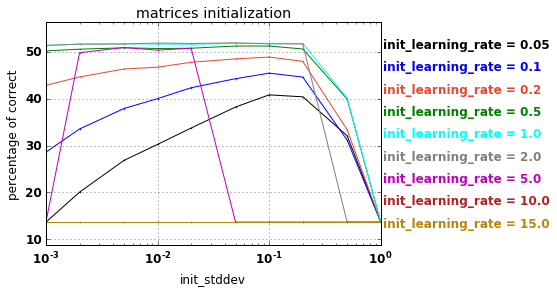

In [18]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_adjustment_plots.one_key_layout_data('delay_deterministic_1_2',
                                                                'init_stddev',
                                         "init_learning_rate")
delay_deterministic_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
delay_deterministic_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

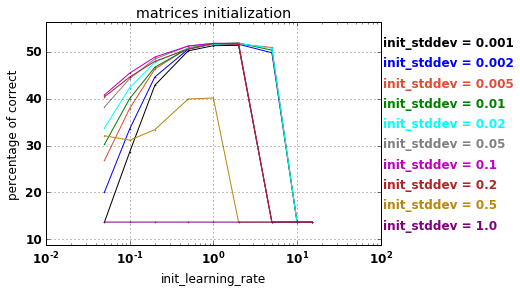

In [20]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_adjustment_plots.one_key_layout_data('delay_deterministic_1_2',
                                                                        "init_learning_rate",
                                                                        'init_stddev')
delay_deterministic_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
delay_deterministic_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

In [21]:
folder_name = 'delay_deterministic'
pickle_file = 'delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal1_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [22]:
from plot_module import ComparePlots

delay_deterministic_adjustment_plots = ComparePlots('delay_deterministic')
delay_deterministic_adjustment_plots.add_network(adjustment_results, model._indices)



Network with such structure is already present


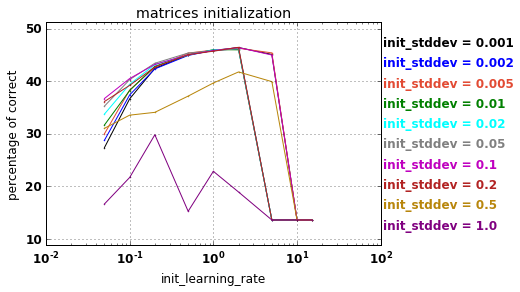

In [24]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_adjustment_plots.one_key_layout_data('delay_deterministic_1_1',
                                                                         "init_learning_rate",
                                                                        'init_stddev')
delay_deterministic_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
delay_deterministic_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

In [11]:
folder_name = 'delay_deterministic'
pickle_file = 'delay_deterministic_adjustment_ns_40000_hl_4000_dc_0.9_nu_10_nal1_nan196_nml1_nmn8_ilr5_.05_std0.001-1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [12]:
from plot_module import ComparePlots

delay_deterministic_adjustment_plots = ComparePlots('delay_deterministic')
delay_deterministic_adjustment_plots.add_network(adjustment_results, model._indices)



In [ ]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_adjustment_plots.one_key_layout_data('delay_deterministic_1_1',
                                                                'init_stddev',
                                         "init_learning_rate")
delay_deterministic_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
delay_deterministic_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

In [8]:

analisys_layers_values = [1, 2, 3, 5]
analisys_nodes_values = [196]
memory_layers_values = [1, 2]
memory_nodes_values = [4, 8, 16]
num_unrollings_value = 30
memory_lengths_values = [3, 5, 6, 10, 15, 30]

results_GL = list()

for analisys_layers_value in analisys_layers_values:
    print(' '*10, "analisys layers: ", analisys_layers_value)
    for analisys_nodes_value in analisys_nodes_values:
        print(' '*8, "analisys nodes: ", analisys_nodes_value)
        for memory_layers_value in memory_layers_values:
            print(' '*6, "memory layers: ", memory_layers_value)
            for memory_lengths_value in memory_lengths_values:
                print(' '*4, "memory lengths: ", memory_lengths_value)
                if memory_layers_value == 1:
                    memory_lengths = [memory_lengths_value]
                else:
                    memory_lengths = [memory_lengths_value, num_unrollings_value / memory_lengths_value]
                for memory_nodes_value in memory_nodes_values:
                    print(' '*2, "memory nodes: ", memory_nodes_value)
                    if memory_layers_value == 2:
                        print('num_unrollings: ', num_unrollings_value)
                    else:
                        print('num_unrollings: ', memory_lengths_value)
                    model = delay_deterministic(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             memory_layers_value,            #number of memory layers
                                             [memory_nodes_value]*memory_layers_value,            #number of memory nodes
                                             memory_lengths,           #memory lengths  
                                             analisys_layers_value,              #number of analisys layers
                                             [analisys_nodes_value]*analisys_layers_value,          #number of analisys nodes
                                             1,              # number of times the highest memory layer fully updates during one epoch
                                                train_text,
                                                valid_text) 
                    model.simple_run(100,
                                       'delay_deterministic/variables/al%s_an%s_ml%s_mlth%s_mn%s' %
                                     (analisys_layers_value,
                                      analisys_nodes_value,
                                      memory_layers_value,
                                      memory_lengths_value,
                                      memory_nodes_value),
                                       40000,
                                       4000,
                                       5000,        #learning has a chance to be stopped after every block of steps
                                       40,
                                       0.9,
                                       3,
                                     fixed_num_steps=True)
                    results_GL.extend(model._results)
                    model.destroy()
                    del model
                    gc.collect()

           analisys layers:  1
         analisys nodes:  196
       memory layers:  1
     memory lengths:  3
   memory nodes:  4
num_unrollings:  3
Number of steps = 40000     Percentage = 40.74%     Time = 164s     Learning rate = 0.0148
   memory nodes:  8
num_unrollings:  3
Number of steps = 40000     Percentage = 44.07%     Time = 172s     Learning rate = 0.0148
   memory nodes:  16
num_unrollings:  3
Number of steps = 40000     Percentage = 46.55%     Time = 179s     Learning rate = 0.0148
     memory lengths:  5
   memory nodes:  4
num_unrollings:  5
Number of steps = 40000     Percentage = 41.88%     Time = 227s     Learning rate = 0.0148
   memory nodes:  8
num_unrollings:  5
Number of steps = 40000     Percentage = 45.42%     Time = 227s     Learning rate = 0.0148
   memory nodes:  16
num_unrollings:  5
Number of steps = 40000     Percentage = 48.21%     Time = 243s     Learning rate = 0.0148
     memory lengths:  6
   memory nodes:  4
num_unrollings:  6
Number of steps = 400

In [9]:
folder_name = 'delay_deterministic'
file_name = 'delay_deterministic_ns_40000_hl_1000_dc_0.9_ilr1._nml1-2_nmn4-16_ml3-30_nal1-5_nan196.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)


Pickling delay_deterministic/delay_deterministic_ns_40000_hl_1000_dc_0.9_ilr1._nml1-2_nmn4-16_ml3-30_nal1-5_nan196.pickle.


In [10]:
folder_name = 'delay_deterministic'
pickle_file = 'delay_deterministic_ns_40000_hl_1000_dc_0.9_ilr1._nml1-2_nmn4-16_ml3-30_nal1-5_nan196.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [11]:
from plot_module import ComparePlots

delay_deterministic_plots = ComparePlots('delay_deterministic')
delay_deterministic_plots.add_network(results_GL, model._indices)



In [11]:
print(results_GL[0]['metadata'][model._indices['analisys_layers']])
print(results_GL[0]['metadata'][model._indices['memory_layers']])

1
1


['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']


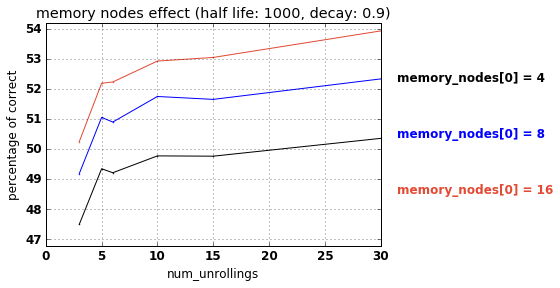

In [17]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_plots.one_key_layout_data('delay_deterministic_1_1',
                                                             'num_unrollings',
                                                             'memory_nodes[0]')
delay_deterministic_plots.save_layout(plot_data[0],
                    'num_unrollings effect (memory_nodes)',
                    ['support_effect', 'plots'],
                    'nal196;ns128;hl1000;dc0.9')
delay_deterministic_plots.draw(plot_data[0], 'memory nodes effect (half life: 1000, decay: 0.9)')

['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean', 'batch_size', 'half_life', 'init_stddev', 'frequency', 'memory_lengths', 'analisys_nodes', 'num_unrollings', 'memory_layers', 'decay', 'averaging_number', 'num_steps', 'analisys_layers', 'init_learning_rate', 'type', 'memory_nodes']
['init_mean'

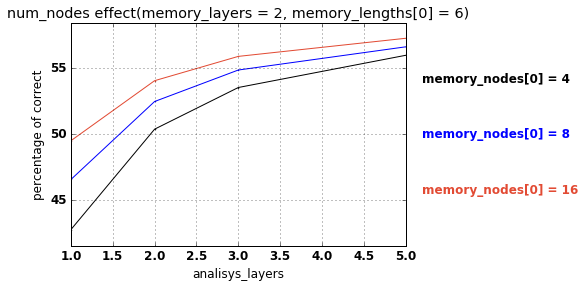

In [23]:
plot_options = {'x': 'log'}
plot_data, _ = delay_deterministic_plots.one_key_layout_data('delay_deterministic_1_1',
                                                             'analisys_layers',
                                                             'memory_nodes[0]',
                                                             limit_variables={'memory_layers': 2, 'memory_lengths[0]': 6})
delay_deterministic_plots.save_layout(plot_data[0],
                    'analisys_layers effect',
                    ['support_effect', 'plots'],
                    'nal196;ns128;hl1000;dc0.9;nl2;ml6;nal-mn[0]')
delay_deterministic_plots.draw(plot_data[0], 'num_nodes effect')